# Quantum gates with "shaped controls"

$
\newcommand{tr}[0]{\operatorname{tr}}
\newcommand{diag}[0]{\operatorname{diag}}
\newcommand{abs}[0]{\operatorname{abs}}
\newcommand{pop}[0]{\operatorname{pop}}
\newcommand{aux}[0]{\text{aux}}
\newcommand{opt}[0]{\text{opt}}
\newcommand{tgt}[0]{\text{tgt}}
\newcommand{init}[0]{\text{init}}
\newcommand{lab}[0]{\text{lab}}
\newcommand{rwa}[0]{\text{rwa}}
\newcommand{bra}[1]{\langle#1\vert}
\newcommand{ket}[1]{\vert#1\rangle}
\newcommand{Bra}[1]{\left\langle#1\right\vert}
\newcommand{Ket}[1]{\left\vert#1\right\rangle}
\newcommand{Braket}[2]{\left\langle #1\vphantom{#2}\mid{#2}\vphantom{#1}\right\rangle}
\newcommand{op}[1]{\hat{#1}}
\newcommand{Op}[1]{\hat{#1}}
\newcommand{dd}[0]{\,\text{d}}
\newcommand{Liouville}[0]{\mathcal{L}}
\newcommand{DynMap}[0]{\mathcal{E}}
\newcommand{identity}[0]{\mathbf{1}}
\newcommand{Norm}[1]{\lVert#1\rVert}
\newcommand{Abs}[1]{\left\vert#1\right\vert}
\newcommand{avg}[1]{\langle#1\rangle}
\newcommand{Avg}[1]{\left\langle#1\right\rangle}
\newcommand{AbsSq}[1]{\left\vert#1\right\vert^2}
\newcommand{Re}[0]{\operatorname{Re}}
\newcommand{Im}[0]{\operatorname{Im}}
$

In [1]:
using DrWatson
@quickactivate "GRAPETests"
using QuantumControl

┌ Info: Precompiling QuantumControl [8a270532-f23f-47a8-83a9-b33d10cad486]
└ @ Base loading.jl:1662


Here, we explore the use of "shaped pulses" in a GRAPE optimization. The physical drive corresponds to the control amplitudes $\Omega(t) = S(t) \epsilon(t)$, where $\epsilon(t)$ is the control function to be optimized via GRAPE. The shape function $S(t)$ is not affected by the optimization. Choosing $S(t)$ to smoothly switch on from zero at $t=0$ and back down to zero at $t=T$ ensures that the optimized controls (and the resulting amplitudes $\Omega(t)$) maintain the same boundary conditions of zero at the beginning and end of the time grid. The role of $S(t)$ here is very similar to the "update shape" $S(t)$ used in Krotov'e method.

The example is adapted from the [GRAPE Example 2](https://juliaquantumcontrol.github.io/GRAPE.jl/stable/examples/perfect_entanglers/).

## Shaped Control Amplitudes Implementation

In [2]:
import QuantumPropagators


"""Time-dependent Hamiltonian with non-trivial control amplitudes.

```julia
Ĥ = Hamiltonian(Ĥ₀, control_terms...)
```

instantiates a time-dependent Hamiltonian from the static drift ``Ĥ₀`` and
an arbitrary number of control terms, where each control term is a tuple
`(Ĥₗ, aₗ)` of a control operator ``Ĥₗ`` and a control amplitude ``aₗ``.

Remember the [Glossary](
https://juliaquantumcontrol.github.io/QuantumControl.jl/dev/glossary/):
control amplitudes ``aₗ(ϵₗ(t))`` contain control functions ("controls")
``ϵₗ(t)``.
"""
struct Hamiltonian{OT,CAT}
    drift::OT
    control_operators::Vector{OT}
    control_amplitudes::Vector{CAT}
    function Hamiltonian(drift, control_terms...)
        @assert length(control_terms) > 1
        OT = typeof(drift)
        CAT = typeof(control_terms[1][2])
        M = length(control_terms)
        new{OT,CAT}(
            drift,
            [control_terms[i][1] for i = 1:M],
            [control_terms[i][2] for i = 1:M]
        )
    end
end

"""Control amplitude ``aₗ(ϵₗ(t)) = S(t) ϵ(t)``."""
struct ShapedControlAmplitude
    control  # ϵ(t)
    shape  # S(t)
end


# for plotting
(Ω::ShapedControlAmplitude)(t::Float64) = Ω.control(t) * Ω.shape(t)


function QuantumPropagators.Controls.substitute_controls(
    generator::Hamiltonian{<:Any,ShapedControlAmplitude},
    controls_map
)
    new_control_terms = [
        (Ĥₗ, ShapedControlAmplitude(get(controls_map, Ω.control, Ω.control), Ω.shape))
        for (Ĥₗ, Ω) in zip(generator.control_operators, generator.control_amplitudes)
    ]
    return Hamiltonian(generator.drift, new_control_terms...)
end


function QuantumPropagators.Controls.getcontrols(
    generator::Hamiltonian{<:Any,ShapedControlAmplitude}
)
    return [Ω.control for Ω in generator.control_amplitudes]
end


function QuantumPropagators.Controls.evalcontrols(
    generator::Hamiltonian{<:Any,ShapedControlAmplitude},
    vals_dict::AbstractDict,
    tlist::Vector{Float64},
    n::Int64
)
    G = copy(generator.drift)
    return QuantumPropagators.Controls.evalcontrols!(G, generator, vals_dict, tlist, n)
end


# Midpoint of n'th interval of tlist, but snap to beginning/end (that's
# because any S(t) is likely exactly zero at the beginning and end, and we
# want to use that value for the first and last time interval)
function _t(tlist, n)
    @assert 1 <= n <= (length(tlist) - 1)  # n is an *interval* of `tlist`
    if n == 1
        t = tlist[begin]
    elseif n == length(tlist) - 1
        t = tlist[end]
    else
        dt = tlist[n+1] - tlist[n]
        t = tlist[n] + dt / 2
    end
    return t
end


function QuantumPropagators.Controls.evalcontrols!(
    G::OT,
    generator::Hamiltonian{OT,ShapedControlAmplitude},
    vals_dict::AbstractDict,
    tlist::Vector{Float64},
    n::Int64
) where {OT}
    copyto!(G, generator.drift)
    for (Ĥₗ, Ω) in zip(generator.control_operators, generator.control_amplitudes)
        val = vals_dict[Ω.control] * Ω.shape(_t(tlist, n))
        axpy!(val, Ĥₗ, G)
    end
    return G
end


function QuantumPropagators.Controls.getcontrolderiv(
    generator::Hamiltonian{<:Any,ShapedControlAmplitude},
    control
)
    for (Ĥₗ, Ω) in zip(generator.control_operators, generator.control_amplitudes)
        if Ω.control ≡ control
            return (v, tlist, n) -> (Ω.shape(_t(tlist, n)) * Ĥₗ)
            # TODO: this can be made more efficient by returning a
            # ScaledOperator and implementing matrix-vector multiplication for
            # it.
        end
    end
    return nothing
end


import QuantumControlBase
using SparseArrays


function QuantumControlBase.dynamical_generator_adjoint(
    G::Hamiltonian{<:Any,ShapedControlAmplitude}
)
    Ĥ₀ = copy(adjoint(G.drift))
    control_terms = [
        (copy(adjoint(Ĥₗ)), Ω) for
        (Ĥₗ, Ω) in zip(G.control_operators, G.control_amplitudes)
    ]
    return Hamiltonian(Ĥ₀, control_terms...)
end

## Hamiltonian and guess pulses

We will write the Hamiltonian in units of GHz (angular frequency; the factor
2π is implicit) and ns:

In [3]:
const GHz = 2π
const MHz = 0.001GHz
const ns = 1.0
const μs = 1000ns;

The Hamiltonian and parameter are taken from Goerz et. al., Phys. Rev. A 91,
062307 (2015)., cf. Table 1 in that Reference.

In [4]:
⊗ = kron
const 𝕚 = 1im
const N = 6  # levels per transmon

using LinearAlgebra
using SparseArrays

function hamiltonian(;
    Ωre,
    Ωim,
    N=N,  # levels per transmon
    ω₁=4.380GHz,
    ω₂=4.614GHz,
    ωd=4.498GHz,
    α₁=-210MHz,
    α₂=-215MHz,
    J=-3MHz,
    λ=1.03,
    use_sparse=:auto
)
    𝟙 = SparseMatrixCSC{ComplexF64,Int64}(sparse(I, N, N))
    b̂₁ = spdiagm(1 => complex.(sqrt.(collect(1:N-1)))) ⊗ 𝟙
    b̂₂ = 𝟙 ⊗ spdiagm(1 => complex.(sqrt.(collect(1:N-1))))
    b̂₁⁺ = sparse(b̂₁')
    b̂₂⁺ = sparse(b̂₂')
    n̂₁ = sparse(b̂₁' * b̂₁)
    n̂₂ = sparse(b̂₂' * b̂₂)
    n̂₁² = sparse(n̂₁ * n̂₁)
    n̂₂² = sparse(n̂₂ * n̂₂)
    b̂₁⁺_b̂₂ = sparse(b̂₁' * b̂₂)
    b̂₁_b̂₂⁺ = sparse(b̂₁ * b̂₂')

    ω̃₁ = ω₁ - ωd
    ω̃₂ = ω₂ - ωd

    Ĥ₀ = sparse(
        (ω̃₁ - α₁ / 2) * n̂₁ +
        (α₁ / 2) * n̂₁² +
        (ω̃₂ - α₂ / 2) * n̂₂ +
        (α₂ / 2) * n̂₂² +
        J * (b̂₁⁺_b̂₂ + b̂₁_b̂₂⁺)
    )

    Ĥ₁re = (1 / 2) * (b̂₁ + b̂₁⁺ + λ * b̂₂ + λ * b̂₂⁺)
    Ĥ₁im = (𝕚 / 2) * (b̂₁⁺ - b̂₁ + λ * b̂₂⁺ - λ * b̂₂)

    if ((N < 5) && (use_sparse ≢ true)) || use_sparse ≡ false
        H = Hamiltonian(Array(Ĥ₀), (Array(Ĥ₁re), Ωre), (Array(Ĥ₁im), Ωim))
    else
        H = Hamiltonian(Ĥ₀, (Ĥ₁re, Ωre), (Ĥ₁im, Ωim))
    end
    return H

end;

We choose a pulse duration of 400 ns. The guess pulse amplitude is 35 MHz,
with a 15 ns switch-on/-off time. The Hamiltonian is written in a rotating
frame, so in general, the control field is allowed to be complex-valued. We
separate this into two control fields, one for the real part and one for the
imaginary part. Initially, the imaginary part is zero, corresponding to a
field exactly at the frequency of the rotating frame.

In [5]:
# XXX
using QuantumControl.Shapes: flattop

function guess_pulses(; T=400ns, E₀=35MHz, dt=0.1ns, t_rise=15ns)

    tlist = collect(range(0, T, step=dt))
    Ωre = ShapedControlAmplitude(
        t -> E₀ * flattop(t, T=T, t_rise=t_rise), # ϵ₁(t)
        t -> flattop(t, T=T, t_rise=t_rise)       # S₁(t)
    )
    Ωim = ShapedControlAmplitude(
        t -> 0.0,                                 # ϵ₂(t)
        t -> flattop(t, T=T, t_rise=t_rise)       # S₂(t)
    )
    return tlist, Ωre, Ωim

end

tlist, Ωre_guess, Ωim_guess = guess_pulses();

We can visualize this:

┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1662


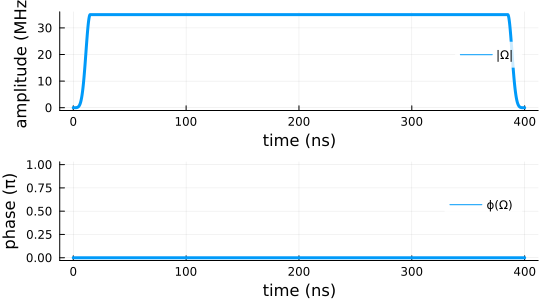

In [6]:
using Plots
Plots.default(
    linewidth               = 3,
    size                    = (550, 300),
    legend                  = :right,
    foreground_color_legend = nothing,
    background_color_legend = RGBA(1, 1, 1, 0.8),
)

function plot_complex_pulse(tlist, Ω; time_unit=:ns, ampl_unit=:MHz, kwargs...)

    ax1 = plot(
        tlist ./ eval(time_unit),
        abs.(Ω) ./ eval(ampl_unit);
        label="|Ω|",
        xlabel="time ($time_unit)",
        ylabel="amplitude ($ampl_unit)",
        kwargs...
    )

    ax2 = plot(
        tlist ./ eval(time_unit),
        angle.(Ω) ./ π;
        label="ϕ(Ω)",
        xlabel="time ($time_unit)",
        ylabel="phase (π)"
    )

    plot(ax1, ax2, layout=(2, 1))

end

plot_complex_pulse(tlist, Ωre_guess.(tlist) + 𝕚 * Ωim_guess.(tlist))

We now instantiate the Hamiltonian with these control fields:

In [7]:
H = hamiltonian(Ωre=Ωre_guess, Ωim=Ωim_guess);

In [8]:
typeof(H)

Hamiltonian{SparseMatrixCSC{ComplexF64, Int64}, ShapedControlAmplitude}

In [9]:
typeof(QuantumControlBase.dynamical_generator_adjoint(H))

Hamiltonian{SparseMatrixCSC{ComplexF64, Int64}, ShapedControlAmplitude}

## Logical basis for two-qubit gates

For simplicity, we will be define the qubits in the *bare* basis, i.e.
ignoring the static coupling $J$.

In [10]:
function ket(i::Int64; N=N)
    Ψ = zeros(ComplexF64, N)
    Ψ[i+1] = 1
    return Ψ
end

function ket(indices::Int64...; N=N)
    Ψ = ket(indices[1]; N=N)
    for i in indices[2:end]
        Ψ = Ψ ⊗ ket(i; N=N)
    end
    return Ψ
end

function ket(label::AbstractString; N=N)
    indices = [parse(Int64, digit) for digit in label]
    return ket(indices...; N=N)
end;

In [11]:
basis = [ket("00"), ket("01"), ket("10"), ket("11")];

## Optimizing for a specific quantum gate

Our target gate is $\Op{O} = \sqrt{\text{iSWAP}}$:

In [12]:
SQRTISWAP = [
    1  0    0   0
    0 1/√2 𝕚/√2 0
    0 𝕚/√2 1/√2 0
    0  0    0   1
];

For each basis state, we get a target state that results from applying the
gate to the basis state (you can convince yourself that this equivalent
multiplying the transpose of the above gate matrix to the vector of basis
states):

In [13]:
basis_tgt = transpose(SQRTISWAP) * basis;

The mapping from each initial (basis) state to the corresponding target state
constitutes an "objective" for the optimization:

In [14]:
objectives = [
    Objective(initial_state=Ψ, target_state=Ψtgt, generator=H) for
    (Ψ, Ψtgt) ∈ zip(basis, basis_tgt)
];

We can analyze how all of the basis states evolve under the guess controls in
one go:

In [15]:
using QuantumControl: propagate_objectives

guess_states = propagate_objectives(objectives, tlist; use_threads=true);

The gate implemented by the guess controls is

In [16]:
U_guess = [basis[i] ⋅ guess_states[j] for i = 1:4, j = 1:4];

We will optimize these objectives with a square-modulus functional

In [17]:
using QuantumControl.Functionals: J_T_sm

The initial value of the functional is

In [18]:
J_T_sm(guess_states, objectives)

0.9192557528648739

which is the gate error

In [19]:
1 - (abs(tr(U_guess' * SQRTISWAP)) / 4)^2

0.9192557528648739

Now, we define the full optimization problems on top of the list of
objectives, and with the optimization functional:

In [20]:
problem = ControlProblem(
    objectives=objectives,
    tlist=tlist,
    iter_stop=100,
    J_T=J_T_sm,
    check_convergence=res -> begin
        (
            (res.J_T > res.J_T_prev) &&
            (res.converged = true) &&
            (res.message = "Loss of monotonic convergence")
        )
        ((res.J_T <= 1e-2) && (res.converged = true) && (res.message = "J_T < 10⁻²"))
    end,
    use_threads=true,
);

In [21]:
opt_result, file = @optimize_or_load(
    datadir(),
    problem;
    method=:GRAPE,
    filename="GATE_OCT_shaped.jld2",
    force=true
);

 iter.        J_T     |∇J_T|       ΔJ_T   FG(F)    secs
     0   9.19e-01   1.35e-01        n/a    1(0)    10.7
     1   8.87e-01   1.35e-01  -3.20e-02    2(0)     5.5
     2   8.76e-01   3.15e-01  -1.12e-02    3(0)     6.5
     3   8.55e-01   4.87e-01  -2.16e-02    1(0)     2.2
     4   8.12e-01   5.23e-01  -4.25e-02    2(0)     4.3
     5   7.57e-01   7.53e-01  -5.48e-02    1(0)     2.2
     6   6.61e-01   1.20e+00  -9.61e-02    1(0)     2.2
     7   6.00e-01   1.67e+00  -6.09e-02    1(0)     2.2
     8   5.07e-01   1.27e+00  -9.28e-02    1(0)     2.2
     9   4.19e-01   1.09e+00  -8.85e-02    1(0)     2.2
    10   3.67e-01   7.13e-01  -5.15e-02    1(0)     2.2
    11   3.20e-01   5.86e-01  -4.71e-02    1(0)     2.2
    12   2.50e-01   5.52e-01  -7.02e-02    1(0)     3.3
    13   1.61e-01   1.10e+00  -8.90e-02    1(0)     2.2
    14   1.46e-01   3.66e-01  -1.51e-02    1(0)     2.2
    15   1.30e-01   2.83e-01  -1.55e-02    1(0)     2.2
    16   9.94e-02   3.50e-01  -3.09e-02    1(0) 

┌ Warning: The Git repository ('/Users/goerz/Documents/Research/2022-09-GRAPE-jl-shaped-controls') is dirty! Appending -dirty to the commit ID.
└ @ DrWatson /Users/goerz/.julia/packages/DrWatson/S4dYA/src/saving_tools.jl:65


In [22]:
opt_result

GRAPE Optimization Result
-------------------------
- Started at 2022-09-26T13:05:55.675
- Number of objectives: 4
- Number of iterations: 28
- Number of pure func evals: 0
- Number of func/grad evals: 34
- Value of functional: 8.45261e-03
- Reason for termination: J_T < 10⁻²
- Ended at 2022-09-26T13:07:20.511 (1 minute, 24 seconds, 836 milliseconds)


We extract the optimized control field from the optimization result and plot
it

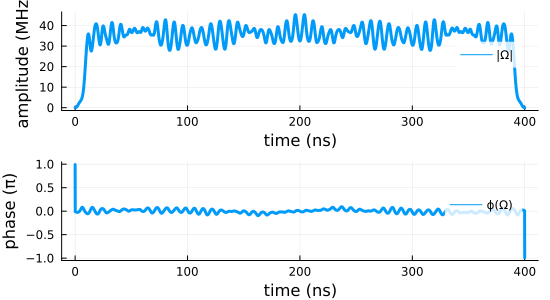

In [23]:
ϵ_opt = opt_result.optimized_controls[1] + 𝕚 * opt_result.optimized_controls[2]
plot_complex_pulse(tlist, ϵ_opt)

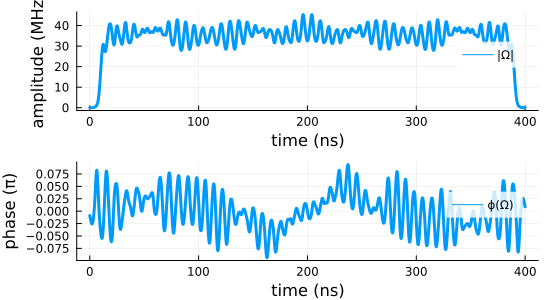

In [24]:
ϵ_opt_func = t -> begin
    n = min(searchsortedfirst(tlist, t), length(tlist))
    return ϵ_opt[n]
end
Ω_opt = ShapedControlAmplitude(ϵ_opt_func, Ωre_guess.shape)

plot_complex_pulse(tlist, Ω_opt.(tlist))

In [25]:
typeof(Ω_opt)

ShapedControlAmplitude

We then propagate the optimized control field to analyze the resulting
quantum gate:

In [26]:
opt_states = propagate_objectives(
    objectives,
    tlist;
    use_threads=true,
    controls_map=IdDict(
        Ωre_guess.control => opt_result.optimized_controls[1],
        Ωim_guess.control => opt_result.optimized_controls[2]
    )
);

The resulting gate is

In [27]:
U_opt = [basis[i] ⋅ opt_states[j] for i = 1:4, j = 1:4];

and we can verify the resulting fidelity

In [28]:
(abs(tr(U_opt' * SQRTISWAP)) / 4)^2

0.9915473898567777

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*